### 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import io
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage as sk
import pandas as pd
import cv2
import seaborn as sns

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from utils.log_progress import *
from utils.tools import *
from utils.config import *
from utils.utils import *

from PIL import Image
from PIL import ImageDraw
from matplotlib.pyplot import imshow, imread, imsave
from skimage.draw import line, line_aa, circle
from skimage.util import img_as_float

import xml.etree.ElementTree as ET
import base64
import warnings
warnings.filterwarnings("ignore")

# 2. Read XML's: 

In [7]:
def get_masks_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    masks = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.FreeFormLabel":
            mask_entry = item.findall("./Mask")
            masks.append(mask_entry[0].text)
    return masks

def get_roots_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    roots = []
    for item in itemlist:
        if item.attrib['Type'] == "csem.Vision.Labels.CircularLabel":
            root_entry = item.findall("./BaseClass/Location")
            pX = float(root_entry[0].text.split(",")[0].replace("(",""))
            pY = float(root_entry[0].text.split(",")[1].replace(")",""))
            roots.append([pX,pY])
    return roots

def get_polygons_from_xml(xml_tree):
    root = xml_tree.getroot()
    itemlist = root.findall("./ParameterNode/Labels/Item/Value/")
    splines = []
    for item in itemlist:
        if item.attrib["Type"] == "csem.Vision.Labels.PolygonLabel":
            polygon_entry = item.findall("./Points/Item")
            spline = []
            for p in polygon_entry:  
                pX = float(p.text.split(",")[0].replace("(",""))
                pY = float(p.text.split(",")[1].replace(")",""))
                spline.append([pX,pY])
            splines.append(spline)
    return splines
            

def create_mask(mask_strings,size,min_size=100):
    merged_masks = np.zeros(size,dtype=bool)
    if not len(mask_strings) >= 1:
        return merged_masks
    
    mask_as_bytes = base64.b64decode(mask_strings[0])
    mask = Image.open(io.BytesIO(mask_as_bytes))
    
    for string in mask_strings:
        mask_as_bytes = base64.b64decode(string)
        mask = Image.open(io.BytesIO(mask_as_bytes))
        'Skip masks which are below min_size:'
        if np.sum(np.array(mask) > 0) > min_size:
            merged_masks += np.array(mask) > 0
    return merged_masks
    
    
def create_df():
    imagelist = []
    for path, subdirs, files in os.walk(Config.RAW_PATH):
        for name in files:
            if name.endswith(".png"):
                fullpath = os.path.join(path, name)
                xmlpath = fullpath[:-4]+".xml"
                imagelist.append((path,name,fullpath,xmlpath))
                
    vals = [[] for i in range(6)]
    
    for path,name,fullpath,xmlpath in log_progress(imagelist,every=1):
        img = Image.open(fullpath,mode="r")
        width, height = img.size
        tree = ET.parse(xmlpath)
        masks = get_masks_from_xml(tree)
        mask = create_mask(masks,(height,width))
        rle = rle_encode(mask)
        roots = get_roots_from_xml(tree)
        splines = get_polygons_from_xml(tree)
        vals[0].append(path)
        vals[1].append(name)
        vals[2].append(rle)
        vals[3].append(roots)
        vals[4].append(splines)
        vals[5].append((height,width))

            
    files = {"Path":vals[0],
             "Name":vals[1],
             "Rle-Encoding":vals[2],
             "Roots":vals[3],
             "Splines":vals[4],
             "Shape":vals[5]}
    df = pd.DataFrame.from_dict(files)
    return df

### Load Existing Dataframe

In [8]:
df_labeling_tool = pd.read_pickle(Config.DATA_BASE_PATH+'/df_labeling_tool')

### Create Dataframe of "Raw" Data:

In [ ]:
df_labeling_tool = create_df()

### Save Dataframe of "Raw" Data:

In [6]:
df_labeling_tool.to_pickle(DATA_BASE_PATH+"/df_labeling_tool")

### Show Samples of DataFrame:

In [10]:
df_labeling_tool.sample(1)

,Path,Name,Rle-Encoding,Roots,Splines,Shape
395,../data/LabelingTool/Prozessschritte_10,20161013D_hamt376_Ampfer-raw.png,592218 12 593364 24 594512 31 595655 40 596801...,"[[835.9017, 798.4736]]","[[[642.0426, 575.3931], [696.2091, 644.5267]],...","(1738, 1151)"


### Show Mask at Index:

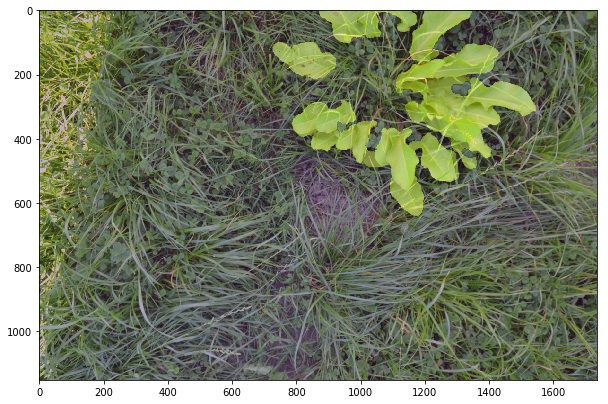

In [11]:
index = 0
mask = rle_decode(df_labeling_tool['Rle-Encoding'][index], df_labeling_tool['Shape'][index])
image = imread(df_labeling_tool['Path'][index] + "/" + df_labeling_tool['Name'][index])
plt.figure(figsize=(10,10))
imshow(mask)
imshow(image,alpha=0.7)

### Show Lines:

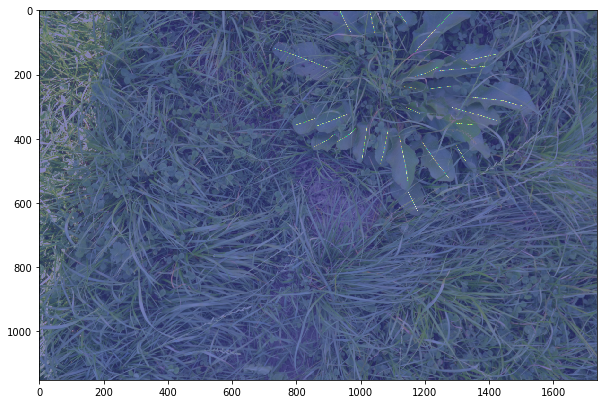

In [12]:
def draw_splines(splines,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for spline in splines:
        s = len(spline)
        for i in range(s-1):
            rr, cc, val = line_aa(int(spline[i][1]), int(spline[i][0]), int(spline[i+1][1]),int(spline[i+1][0]))
            img[rr, cc] = val*255
    return img
   
splines = draw_splines(df_labeling_tool['Splines'][index],df_labeling_tool['Shape'][index])
plt.figure(figsize=(10,10))
imshow(image)
imshow(splines,cmap='terrain',alpha=0.6)

### Show Roots:

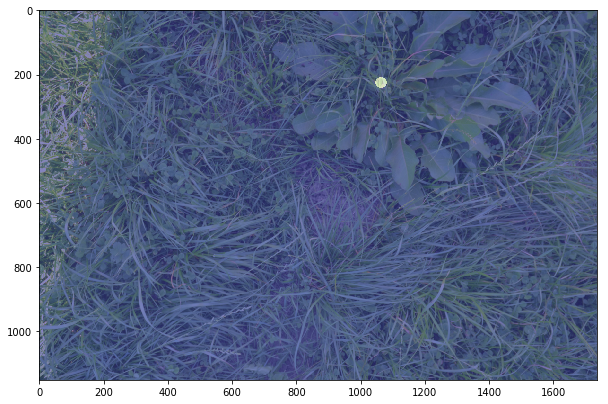

In [13]:
def draw_roots(roots,shape):
    img = np.zeros(shape, dtype=np.uint8)
    for root in roots:
            rr, cc = circle(int(root[1]),int(root[0]),max(shape)/100)
            try:
                img[rr, cc] = 1
            except:
                pass
    return img

roots = draw_roots(df_labeling_tool['Roots'][index],df_labeling_tool['Shape'][index])
plt.figure(figsize=(10,10))
imshow(image)
imshow(roots,cmap='terrain',alpha=0.6)

# 3. Create new Dataframe and save as Standardized Images and Masks:

In [14]:
# Rotates and Resizes Image, Mask, Roots and Splines:
def rotate_and_resize(im,msk,roots,lines,output_size=(1024,1536),scale_factor=1.0,rotate_angle=90):
    #from: https://stackoverflow.com/questions/11764575/python-2-7-3-opencv-2-4-after-rotation-window-doesnt-fit-image
    
    assert rotate_angle == 90 or rotate_angle == 0, "rotate_angle must be 0 or 90°"
    
    oldY = im.shape[0] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    oldX = im.shape[1]
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=rotate_angle, scale=scale_factor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scale_factor,oldY*scale_factor
    
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(rotate_angle)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty
    
    # Transform image and mask
    im_rotated = cv2.warpAffine(im, M, dsize=(int(newX),int(newY)))
    msk_rotated = cv2.warpAffine(msk, M, dsize=(int(newX),int(newY)))
    
    transformed_lines = []
    for line in lines:
        ones_line = np.ones(shape=(len(line), 1))
        line_ones = np.hstack([line, ones_line])
        transformed_lines.append(M.dot(line_ones.T).T) 
    
    # add ones
    ones_roots = np.ones(shape=(len(roots), 1))

    roots_ones = np.hstack([roots, ones_roots])

    # transform roots and lines
    transformed_roots = M.dot(roots_ones.T).T
    
    if (oldY < oldX and rotate_angle==0) or (oldY > oldX and rotate_angle==90):
        output_size= (output_size[1],output_size[0])
    
    # resize image, mask and roots
    shape_old = im_rotated.shape
    im_rotated = cv2.resize(im_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    msk_rotated = cv2.resize(msk_rotated,output_size, interpolation = cv2.INTER_CUBIC)
    
    ratioX = shape_old[1]/im_rotated.shape[1]
    ratioY = shape_old[0]/im_rotated.shape[0]
    for root in transformed_roots:
        root[0] = root[0] / ratioY
        root[1] = root[1] / ratioX
    for lines in transformed_lines:
        for line in lines:
            line[0] = line[0] / ratioY
            line[1] = line[1] / ratioX
    
    # make sure the image and mask is in range [0,1]
    im_rotated = im_rotated/im_rotated.max()
    msk_rotated = msk_rotated/msk_rotated.max()
    
    return im_rotated, msk_rotated, transformed_roots, transformed_lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


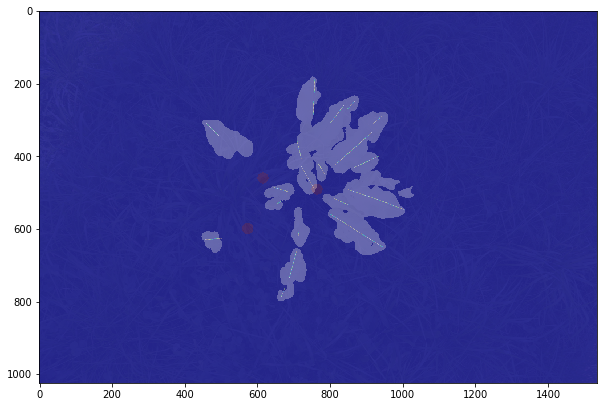

In [15]:
# Show sample:
index = 11

mask = rle_decode(df_labeling_tool['Rle-Encoding'][index], df_labeling_tool['Shape'][index])
image = imread(df_labeling_tool['Path'][index] + "/" + df_labeling_tool['Name'][index])

roots = df_labeling_tool['Roots'][index]
lines = df_labeling_tool['Splines'][index]

plt.figure(figsize=(10,10))
rotated_im, rotated_msk, rotated_roots, rotated_lines = rotate_and_resize(image,mask,roots,lines,rotate_angle=0)

imshow(rotated_im)
imshow(draw_roots(rotated_roots,(rotated_im.shape[0],rotated_im.shape[1])),cmap='jet',alpha=0.8)
imshow(draw_splines(rotated_lines,(rotated_im.shape[0],rotated_im.shape[1])),cmap='terrain',alpha=0.6)
imshow(rotated_msk,cmap='terrain',alpha=0.3)

### Save Data and Create new Dataframe

In [16]:
def save_data(df):
    i = 0
    vals = [[] for i in range(9)]
    for index, image in log_progress(df.iterrows(),every=1,size=len(df)):
        read_path = os.path.join(image['Path'],image['Name'])
        im = imread(read_path)
        msk = rle_decode(image['Rle-Encoding'], image['Shape'])

        roots = image['Roots']
        splines = image['Splines']

        if image['Shape'][0] > image['Shape'][1]:
            im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=90)
        else:
            im, msk, roots, splines = rotate_and_resize(im,msk,roots,splines,output_size=(1024,1536),rotate_angle=0)

        msk_auto_gen = np.zeros(im.shape, dtype=np.uint8)
        for root in roots:
            rr, cc = circle(int(root[1]), int(root[0]), max(im.shape[0],im.shape[1])/10)
            try:
                msk_auto_gen[rr, cc] = 255
            except:
                pass
        msk_auto_gen = sk.img_as_float(msk_auto_gen)
        
        save_path = '../data/00_all/'
        data_set = 'None'

        name = "img_" + str(1000+i) + ".png"
        image_path = save_path+'images/'
        mask_path = save_path+'masks/'
        mask_circle_path = save_path+'masks_autogen/'
        #print(msk_auto_gen.max())
        vals[0].append(image_path)
        vals[1].append(mask_path)
        vals[2].append(mask_circle_path)
        vals[3].append(name)
        vals[4].append(data_set)
        vals[5].append(rle_encode(msk>0.5))
        vals[6].append(rle_encode(msk_auto_gen>0.5))
        vals[7].append(roots)
        vals[8].append(splines)
        
        #print(im.shape)

        sk.io.imsave(image_path + name,im)
        sk.io.imsave(mask_path + name,msk)
        #sk.io.imsave(mask_circle_path + name,msk_auto_gen)
        i+=1
            
    files = {"image_path":vals[0],
             "mask_path":vals[1],
             "mask_cirlce_path":vals[2],
             "name":vals[3],
             "dataset":vals[4],
             "mask_rle":vals[5],
             "mask_circle_rle":vals[6],
             "roots":vals[7],
             "splines":vals[8]}
    return pd.DataFrame.from_dict(files)

### Save:

In [ ]:
df = save_data(df_labeling_tool)

In [19]:
df = pd.read_pickle(Config.DATA_BASE_PATH+'/df')

In [20]:
df.sample(1)

,image_path,mask_path,mask_cirlce_path,name,dataset,mask_rle,mask_circle_rle,roots,splines
33,../data/00_all/images/,../data/00_all/masks/,../data/00_all/masks_autogen/,img_1033.png,None,1690 120 1833 1 1860 4 3226 120 3365 9 3393 11...,1024 1098 5629 1104 10237 1107 14842 1113 1944...,"[[590.042144917463, 100.37468354430383], [469....","[[[1176.7886290182448, 423.7973357882625], [12..."


In [13]:
df.to_pickle(Config.DATA_BASE_PATH+"/df")

### Load Splited Data

In [4]:
train_df = pd.read_pickle(Config.DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(Config.DATA_BASE_PATH+'/val_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))

Number of training Samples: 405
Number of validation Samples: 102


### DONT DO THIS!

In [52]:
# shuffle
import math
df_shuffeled = df.sample(frac=1)
train_size = 0.8
val_size = 0.2
test_size = 0.0
samples = len(df_shuffeled)

train_ind = math.floor(samples*train_size)
val_ind = train_ind + math.floor(samples*val_size)
test_ind = train_ind + val_ind + math.floor(samples*test_size)

train_df = df_shuffeled[0:train_ind].reset_index(drop=True)
val_df = df_shuffeled[train_ind:val_ind+1].reset_index(drop=True)
test_df = df_shuffeled[val_ind:-1].reset_index(drop=True)

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 405
Number of validation Samples: 102
Number of test Samples: 0


In [53]:
train_df.to_pickle(Config.DATA_BASE_PATH+"/train_df")
val_df.to_pickle(Config.DATA_BASE_PATH+"/val_df")
test_df.to_pickle(Config.DATA_BASE_PATH+"/test_df")

### 4.1 Roots per Image:

In [6]:
df_all = pd.concat([train_df.assign(dataset='train'), val_df.assign(dataset='val')])

Text(0.5,1,'Distribution of Roots per Image')

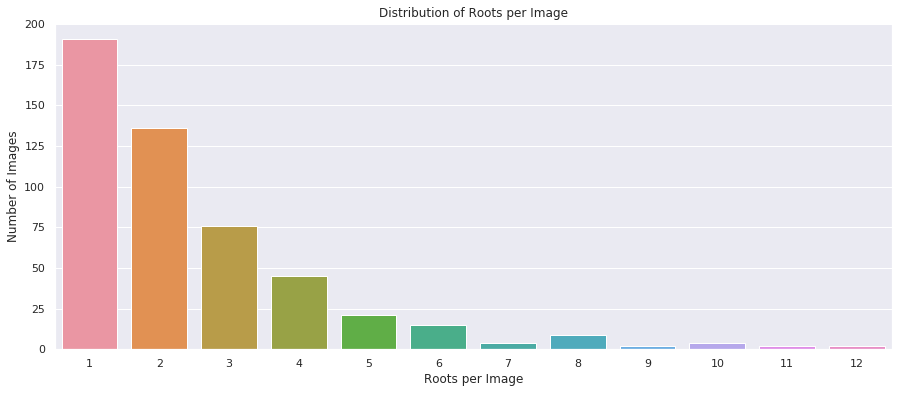

In [7]:
sns.set(style="darkgrid")
x = [len(row['roots']) for _,row in df_all.iterrows()]
x,y = np.unique(x,return_counts=True)
data = {"Number of Images":y[::-1],
         "Roots per Image":x[::-1]}
data = pd.DataFrame.from_dict(data)
plt.figure(figsize=(15,6))
sns.barplot(x="Roots per Image",y="Number of Images",data=data).set_title("Distribution of Roots per Image")

In [20]:
print(str(sum(y[:3])/sum(y)) + " % of all Images containing 3 or less individual plants per image")

0.7948717948717948 % of all Images containing 3 or less individual plants per image


### 4.2 Visualize Root Distribution:

In [22]:
#create temporary dataframe:
x_roots = []
y_roots = []
paths = []
for _,row in df_all.iterrows():
    for root in row['roots']:
        x_roots.append(root[0])
        y_roots.append(root[1])
        paths.append(row['dataset'])
        
root_coordinates = [('x', x_roots),
                 ('y', y_roots),
                    ('dataset',paths)]
df_root_coordinates = pd.DataFrame.from_items(root_coordinates)
df_root_coordinates.sample(3)

,x,y,dataset
852,168.396311,575.930535,train
414,654.884743,365.240385,train
1052,775.768432,499.896061,val


(0, 1024)

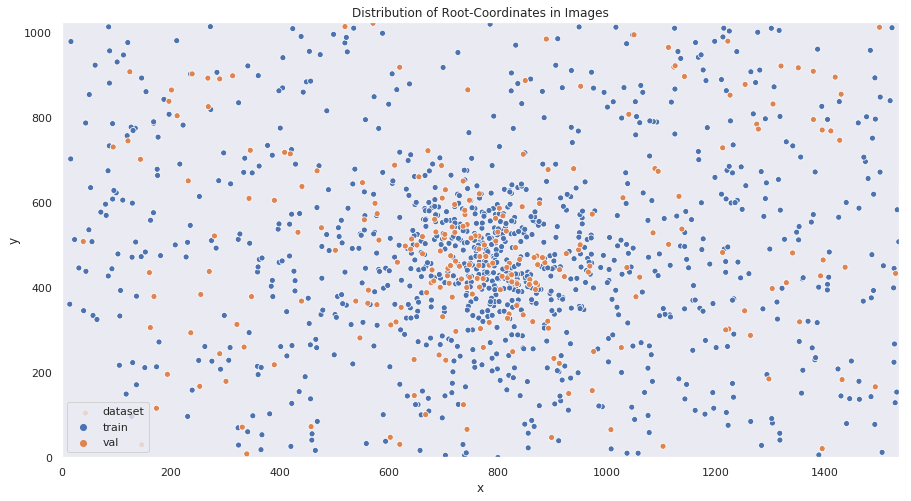

In [23]:
plt.figure(figsize=(15,8))
sns.set(style="dark")
ax = sns.scatterplot(x="x", y="y",hue="dataset", data=df_root_coordinates)
ax.set_title("Distribution of Root-Coordinates in Images")
plt.xlim(0, 1536)
plt.ylim(0, 1024)

(0, 1024)

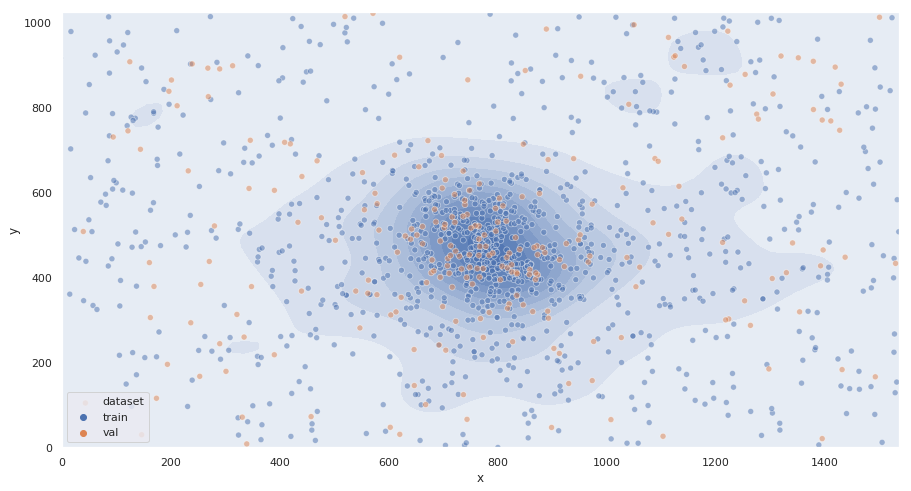

In [43]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df_root_coordinates.x.values, df_root_coordinates.y.values, shade=True)
#plt.scatter(df_root_coordinates.loc[df_root_coordinates['dataset'] == "train"].x.values, df_root_coordinates.loc[df_root_coordinates['dataset'] == "train"].y.values, marker='x', color='black', alpha=0.5)
#plt.scatter(df_root_coordinates.loc[df_root_coordinates['dataset'] == "val"].x.values, df_root_coordinates.loc[df_root_coordinates['dataset'] == "val"].y.values, marker='x', color='orange', alpha=0.5)
ax = sns.scatterplot(x="x", y="y",hue="dataset", data=df_root_coordinates, alpha=0.5)
plt.xlim(0, 1536)
plt.ylim(0, 1024)

### 4.3 Visualize Mask Distribution:

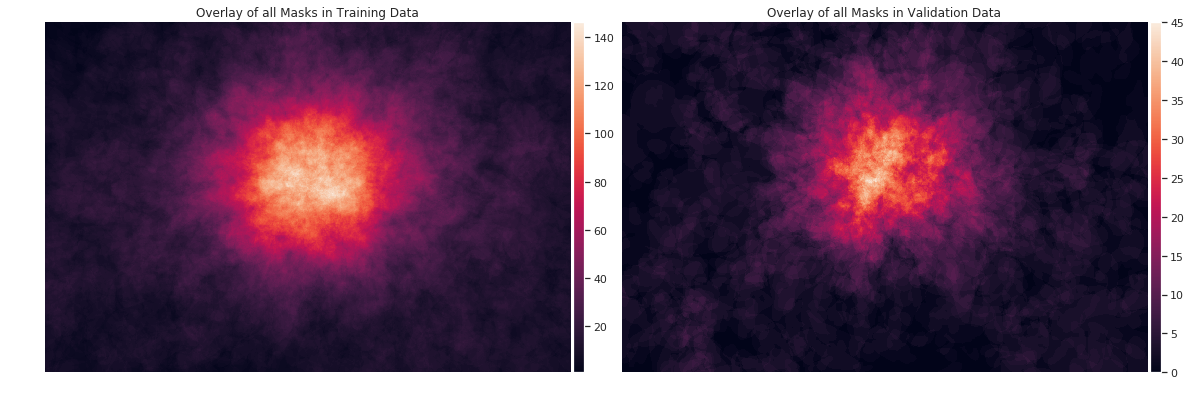

In [44]:
shape = (1024,1536)
summed_mask_train = np.zeros(shape)
summed_mask_val = np.zeros(shape)
for i,row in df_all.iterrows():
    if row['dataset'] == 'train':
        summed_mask_train += rle_decode(row['mask_rle'],shape)
    if row['dataset'] == 'val':
        summed_mask_val += rle_decode(row['mask_rle'],shape)

from mpl_toolkits.axes_grid1 import make_axes_locatable        
        
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(20,20))
im0 = axs[0].imshow(summed_mask_train)
im1 = axs[1].imshow(summed_mask_val)
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all Masks in Validation Data')
axs[1].axis('off')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


plt.subplots_adjust(wspace=0.07, hspace=0)